# The correlation between family income and membersship of the Danish church.

In this project we want to examine whether there is a correlation between average family income and membership status at the Danish church. We do this by downloading two datasets from the API of Denmarks Statistics: One holds information on the average disposable family income, the other holds information on membership status, and both datasets are categorised on municipalities and year.  We then clean these datasets, so they are ready for merge. Followingly, we present the data in maps of Denmark, one map for each variable (plus two interactive maps), and from this we look at whether there is a correlation or not. For the maps, we only consider the year of 2021. Further, to see the correlation more clearly, and to see how it changes over years, we also supply an interactive scatterplot for each year that the merged dataset allows.

To make the maps of Denmark we use packages from the following link: https://github.com/Neogeografen/dagi

Imports and set magics:

In [1]:
#Necessary to create the maps below
%pip install geopandas
%pip install mapclassify
%pip install folium
%pip install branca


import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from dstapi import DstApi


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 1. Read and clean data

We have three data sets overall: 
1. Data for the **average family income**. 
2. Data for numbers of **member of the church**. 
3. Data for the **location of municipalities**. 

In [2]:
#loading the DstAPI
inc = DstApi('INDKP132')
church = DstApi('KM6')

Our objective for the merged dataset is to have one row for each municipality and year (sorted). For each row we want information on:

* Number of members of the National Church
* Number of non-members of the National Church
* Share of non-members of the National Church (we use non-members to easier see correlation between religiousity and income, as we expect a negative correlation)
* Average family income in DKK
* Average family income in 1000 DKK

**1.1 Income data (Tabel: Inc):**

We want the following columns: *Municipality, Year, Average family income in DKK*. 
After getting the dataset we therefore perform the following operations (also described in the code):

1. Sort the data by municipality, year and family type
2. Keeping relevant columns (Step *inc_table_000*)
3. Only keeping rows for families (Step *inc_table_010*)
4. Rename variables to streamline for later merge (Step *inc_table_020*)

1.1.1 Loading the data:

In [3]:
#We specify what we select from the dataset. We want the average family income, and we want to see the total and 
#not specific income intervals.
params = {'table': 'indkf132',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'ENHED', 'values': ['117']}, #Average income for families in the group (DKK)
  {'code': 'FAMTYP', 'values': ['*']},
  {'code': 'INDKINTB', 'values': ['99']}, #Total
  {'code': 'Tid', 'values': ['*']}]}

#We apply the dictionary created above to get our dataset.
inc_table = inc.get_data(params=params)

#We show the first 5 lines
inc_table.head(5)

OMRÅDE                                           ENHED  \
0  Kolding  Average income for families in the group (DKK)   
1  Kolding  Average income for families in the group (DKK)   
2  Kolding  Average income for families in the group (DKK)   
3  Herning  Average income for families in the group (DKK)   
4  Herning  Average income for families in the group (DKK)   

                 FAMTYP INDKINTB   TID  INDHOLD  
0  Single people, total    Total  2016   206039  
1        Couples, total    Total  2016   524153  
2       Families, total    Total  2016   363908  
3        Couples, total    Total  2016   510963  
4       Families, total    Total  2016   362373

1.1.2 Cleaning the data:

In [4]:
#We sort the data by municipality, year and family type.
inc_table.sort_values(by=['OMRÅDE', 'TID', 'FAMTYP'], inplace=True)

#Only keeping relevant columns to simplify the data set
inc_table_000=inc_table.loc[:, ['OMRÅDE', 'TID', 'FAMTYP','INDHOLD']]

#We only save average income for families (for each municipality and year)
I = inc_table_000.FAMTYP.str.contains('Families, total')
inc_table_010 = inc_table_000.loc[I,['OMRÅDE', 'TID', 'INDHOLD']]

#We rename variables. The first two are made for inner join latter in the code. The last variable is
#to give a more meaningful name. 
inc_table_020=inc_table_010.rename(columns={'OMRÅDE':'MUNICIPALITY', 'TID':'YEAR','INDHOLD': 'AVG_FAM_INC'})

1.1.3 Presenting the cleaned income dataset:

In [5]:
inc_table_020.head(5)

MUNICIPALITY  YEAR  AVG_FAM_INC
3706     Aabenraa  1987       131927
6510     Aabenraa  1988       138860
4687     Aabenraa  1989       147163
1023     Aabenraa  1990       152107
2681     Aabenraa  1991       160383

**1.2. Church data (Tabel: Church):**

We want the following columns: *Municipality, Year, Sum for members of church and Sum for non members of the church*. After getting the dataset we therefore perform the following operations (Also described in the code):

1. Sort the data by municipality, year and membership status of the church. 
2. Rename variables in order to allign with the income dataset. (Step *church_table_000*)
3. Calculate the numbers of members and non-members of the church. This is done with a group by. (Step *church_grouped*) 
4. We need the columns for Index, municipality and year. (Step *church_table_020*)
5. Left join the sums (*church_grouped*) for member statistics. (Step *church_table_030*)
6. Transpose it in step *church_table_040* in order to have the columns for the member statistics.

1.2.1 Loading the data:

In [9]:
#The displays the different variables. However deactivated after the first initial steps. : 
#tabsum = church.tablesummary(language='en')
#for variable in tabsum['variable name']:
    #print(variable+':')
    #display(church.variable_levels(variable, language='en'))

#We define a dictionary that loads all variables in the church dataset.
params = church._define_base_params(language='en')

#We load the dataset from the DST API and load all variables using the dictionary created above
church_table = church.get_data(params=params)

#We show the first 5 lines
church_table.head(5)

KOMK  KØN        ALDER                          FKMED   TID  INDHOLD
0  Herlev  Men  60-64 years  Not member of National Church  2023      282
1  Herlev  Men  65-69 years      Member of National Church  2023      508
2  Herlev  Men  65-69 years  Not member of National Church  2023      243
3  Herlev  Men  70-74 years      Member of National Church  2023      424
4  Herlev  Men  70-74 years  Not member of National Church  2023      190

1.2.2 Cleaning the data:

In [7]:
#We sort the data
church_table.sort_values(by=['KOMK', 'TID', 'FKMED'], inplace=True)

#Rename variables
church_table_000=church_table.rename(columns={'KOMK':'MUNICIPALITY','TID':'YEAR','INDHOLD':'NUMBER_OF_INDIVIDUALS'})

#We calculate the number of members and non-members for each municipality and year
church_grouped=church_table_000.groupby(['MUNICIPALITY', 'YEAR', 'FKMED'])['NUMBER_OF_INDIVIDUALS'].apply('sum')

#We drop duplicates, so we only have one row per municipality, year and membership status
church_table_010 = church_table_000.drop_duplicates(subset=['MUNICIPALITY', 'YEAR', 'FKMED'])

#We only keep the categorical variables as we will merch the numbers on in the next step
church_table_020=church_table_010.loc[:,['MUNICIPALITY', 'YEAR', 'FKMED']]

#We now merge the grouped values on the dataset.
church_table_030 = church_table_020.set_index(['MUNICIPALITY', 'YEAR', 'FKMED']).join(church_grouped, how='left').reset_index()

#We transpose to get a variable for each outcome of FKMED. This is useful for the figures later on. 
church_table_040 = church_table_030.pivot(index=['MUNICIPALITY', 'YEAR'], columns='FKMED', values='NUMBER_OF_INDIVIDUALS').reset_index()

1.2.3 Presenting the cleaned church dataset

In [8]:
church_table_040.head(5)

FKMED MUNICIPALITY  YEAR  Member of National Church  \
0         Aabenraa  2011                      50190   
1         Aabenraa  2012                      49808   
2         Aabenraa  2013                      49157   
3         Aabenraa  2014                      48630   
4         Aabenraa  2015                      48314   

FKMED  Not member of National Church  
0                               9605  
1                               9792  
2                              10051  
3                              10340  
4                              10590

**1.3 Merge of income and church data**

In this step we are merging the two datasets by a left join. Further, we are changing two municipalities names in order to make it fit with the geopositional data. 

Further, we calculate the following two variables: 

1. % of the population who are *members of the church*
2. Average family income in 1000 DKK.

In [12]:
#We do an inner join, as the datasets are not covering the same periods.
merged_000 = pd.merge(church_table_040,inc_table_020,how='inner',on=['MUNICIPALITY','YEAR'])

#Changing names - We have to do this so it fits with the geojson file. 
merged_000.loc[merged_000.MUNICIPALITY == 'Copenhagen', 'MUNICIPALITY'] = 'København'
merged_000.loc[merged_000.MUNICIPALITY == 'Høje-Taastrup', 'MUNICIPALITY'] = 'Høje Taastrup'

#We calculate two variables:
# 1) % of the population which is not a member of the church
# 2) average disposable family income in 1000 DKK
merged_000['% non-members']=round(100*(1-merged_000['Member of National Church']
                            /(merged_000['Member of National Church']+merged_000['Not member of National Church'])), 2)
merged_000['avg_fam_inc_1000']=round(merged_000['AVG_FAM_INC']/1000,0)

**1.4 Loading geographic data**

In [13]:
# This code makes sure that we can can connect the names of the municipalities with the geographic locations of the municipalities. 
gdf = gpd.read_file('kommuner.geojson')
#Renaming so we have the same variable name.
gdf_000=gdf.rename(columns={'KOMNAVN':'MUNICIPALITY'})

**1.5 Merging data from DST with geographical data**

In [17]:
#Merging the locational data with the (merged) datasets from Statistics Denmark
merged_010 = pd.merge(merged_000,gdf_000,how='left',on=['MUNICIPALITY'])

**1.6 Presenting the final dataset**

In [15]:
merged_010.head(5)

MUNICIPALITY  YEAR  Member of National Church  \
0     Aabenraa  2011                      50190   
1     Aabenraa  2011                      50190   
2     Aabenraa  2011                      50190   
3     Aabenraa  2012                      49808   
4     Aabenraa  2012                      49808   

   Not member of National Church  AVG_FAM_INC  % non-members  \
0                           9605       310961          16.06   
1                           9605       310961          16.06   
2                           9605       310961          16.06   
3                           9792       316597          16.43   
4                           9792       316597          16.43   

   avg_fam_inc_1000 KOMKODE                                           geometry  
0             311.0    0580  POLYGON Z ((9.51098 54.85795 -999.00000, 9.512...  
1             311.0    0580  POLYGON Z ((9.09249 55.02429 -999.00000, 9.087...  
2             311.0    0580  POLYGON Z ((9.55283 55.11080 -999.00000, 9.552...  
3             317.0    0580  POLYGON Z ((9.51098 54.85795 -999.00000, 9.512...  
4             317.0    0580  POLYGON Z ((9.09249 55.02429 -999.00000, 9.087...

The geometry column has no intuitive interpretation and is solely relevant for the map plots we produce later.

# 2. Analysis

**2.1 Maps**

Text(0.5, 1.0, 'Non-Members of the Danish Church (2021)')

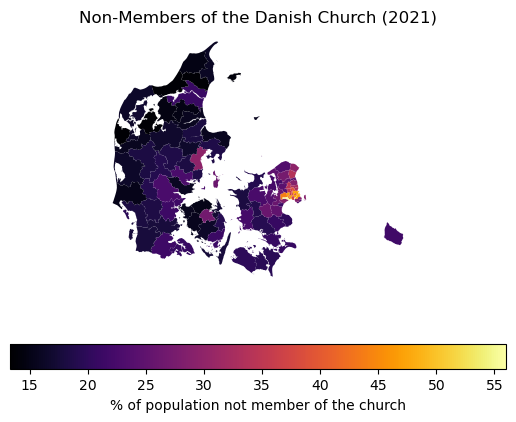

In [21]:
#We choose the year 2021 for the maps. 
merged_015=merged_010.loc[merged_010['YEAR']==2021]

#Make it into a geodataframe. This is needed to show the map. 
merged_020 = gpd.GeoDataFrame(merged_015, geometry='geometry')

#Plotting. cmap is the color. set_axis_off removes latitude and longitude as they are not used. 
merged_020.plot(column='% non-members', 
                legend=True, 
                cmap='inferno',
                legend_kwds={'label': "% of population not member of the church", 'orientation': "horizontal"} 
                ).set_axis_off()
#Give it a title. 
plt.title("Non-Members of the Danish Church (2021)")

Text(0.5, 1.0, 'Average family income (2021)')

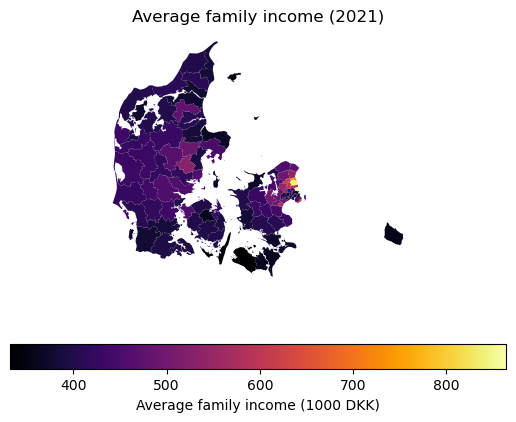

In [22]:
#Making map with income. 
merged_020.plot(column='avg_fam_inc_1000', 
                legend=True, 
                cmap='inferno',
                legend_kwds={'label': "Average family income (1000 DKK)", 'orientation': "horizontal"} 
                ).set_axis_off()
plt.title("Average family income (2021)")

Note: To scroll past the interactive maps, you have to hold your curser over the croller to the right.

In [25]:
#Making an interactive map, where we can see the values for all municipalities. 

#columns specifies the variable that we are mapping over, cmap is the color, width and height specify the size of the map.
merged_020.explore(column='% non-members', 
                   legend=True, 
                   legend_kwds={'label': "% of population", 'orientation': "horizontal"},
                   cmap='inferno',
                   width='70%',
                   height='70%',
                   highlight=True)


In [26]:
merged_020.explore(column='avg_fam_inc_1000', 
                   legend=True, 
                   legend_kwds={'label': "Average Family Income (1000 DKK)", 'orientation': "horizontal"},
                   cmap='inferno',
                   width='70%',
                   height='70%',
                   highlight=True)

From the maps we see something resembling a negative correlation between average family disposable income and being a member of the Danish church. For example, the municipalities around Copenhagen have a tendency towards a high income, but a low percentage of membership in the Danish Church. On the other hand, we see a tendency for low income the Southern and Western part of Denmark, where we at the same time can see a high % for members of the church. 

It should be stated that for instance in Copenhagen, people could be members of other religious communities. Therefore, the correlation could be due to omitted variables and not that higher income leads to lower religiosity (Or lower religiosity could lead to higher income).

**2.2 Scatterplot**

We now proceed to show an interactive scatterplot for the correlation between average family disposable income and membership status over the available years in the data.

In [27]:
#Add scatter with slider. We use the dataset for all periods in order to have a slider with the periods
#This is dataset merged_010 as we only keep 2021 in merged_015
def figure(time):
    
    scatter_000 = merged_010[merged_010['YEAR'] == time]
    fig=plt.figure(dpi=100)
    ax=fig.add_subplot(1,1,1)
    ax.scatter(scatter_000['% non-members'], scatter_000.avg_fam_inc_1000, color=(148/255.,141/255.,134/255.))

    ax.set_title('Non members of church and average family income: 2011-2021', color=(7/255., 9/255., 74/255.))
    ax.set_xlabel('Non members of the church in % of population', color=(7/255., 9/255., 74/255.))
    ax.set_ylabel('Average family income (1000 DKK)', color=(7/255., 9/255., 74/255.))
    ax.grid(True)

    ax.set_xlim(0,70)
    ax.set_ylim(200,900)


    plt.show()

In [28]:
widgets.interact(figure, 
                 time=widgets.FloatSlider(min=merged_010['YEAR'].min(), 
                                          max=merged_010['YEAR'].max(), 
                                          step=1, 
                                          value=merged_010['YEAR'].max(), 
                                          readout_format='.0f'))

interactive(children=(FloatSlider(value=2021.0, description='time', max=2021.0, min=2011.0, readout_format='.0…

<function __main__.figure(time)>

Here we again see a negative correlation between membership status and average family disposable family income. Notably, we see this correlation persist over time, and we see that the municipalities have a smaller share of members over time, whilst income is increasing over time.

# Conclusion

We conclude that there seems to be a negative correlation between the share of members of the Danish church and the average family disposable income: That is, municipalities with a high average family disposable income also typically have a low share of members of the Danish church. It should be noted that the graphs shown above do not enable us to say anything about causality, it is purely correlations. There could be a range of omitted variables, such as membership of a different religion or experiencing a family crisis.